# Estimating the Numer of Active Communicative Civilizations in our Galaxy
<a id="task"></a>

<img width=200 src=https://upload.wikimedia.org/wikipedia/commons/d/df/PurportedUFO2.jpg>


- **How many alien species are in our galaxy that we could actually communicate with?**
- **What would a [Fermi estimate](https://en.wikipedia.org/wiki/Fermi_problem) on this look like?**

Let's try to identify the driving factors of the problem and how they interact. The [Drake equation](https://en.wikipedia.org/wiki/Drake_equation) gives a common answer to the driving forces and clues on their values/magnitudes.

In this Notebook I'll try to get insights on the distribution of possible results by utilizing [Monte Carlo Sampling methods](https://en.wikipedia.org/wiki/Monte_Carlo_method). The idea is to sample thousand of plausible values of the factors and aggregate inspect the resulting distribution of the target variable.

**Hovever, the real reason behind this Notebook is that I want to dive deeper into probabilistic programming and want to take an initial look at PymC3.**

## The Drake Equation

$N = R_* \cdot f_p \cdot n_e \cdot f_l \cdot f_c \cdot L$

with the following individual paramerters meaning:
- $N$ number of civilizations in our galaxy with which communication might be possible
- $R_*$ average rate of star formation in our galaxy
- $f_p$ fraction of stars that have planets
- $n_e$ average number of planets that can potentially support life
- $f_l$ fraction of planets that actually develop life
- $f_i$ fraction of planets that develop intelligent life
- $f_c$ fraction of civilizations that release detectable signs
- $L$ length of time for which such signals are detectable 

# Approaches

1. Uninformed
2. Informed
3. Enhanced Version of informed

## Taking an Uninformed Guess

The estimates of the **Parameters follow a uniform distribution**. Bounds for the parameters are either taken from the Wikipedia article, or educated guesses.

| Parameter | Estimate    |
| :-:       | :-:         |
| $R_*$     | 0.68 - 1.45 |
| $f_p$     | 0.5 - 1     |
| $n_e$     | 0 - 5       |
| $f_l$     | 0.8 - 1     |
| $f_i$     | 0.2 - 0.8   |
| $f_c$     | 0.1 - 0.2   |
| $L  $     | 0 - 5000    |

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

%matplotlib inline

### Sampling Possible Outcomes

In [2]:
with pm.Model() as model_uninformed:
    # Model parameters
    R   = pm.Uniform(r'$R_*$ - Star formation rate', lower=0.68 , upper=1.45)
    f_p = pm.Uniform(r'$f_p$ - Fraction of planets', lower=0.5 , upper=1)
    n_e = pm.Uniform(r'$n_e$ - Number of planets supporting life', lower=0 , upper=5)
    f_l = pm.Uniform(r'$f_l$ - Fraction of life', lower=0.8 , upper=1)
    f_i = pm.Uniform(r'$f_i$ - Fraction of intelligent', lower=0.2 , upper=0.8)
    f_c = pm.Uniform(r'$f_c$ - Fraction of communicate', lower=0.1 , upper=0.2)
    L   = pm.Uniform(r'$L$ - Length of detectable communication', lower=100 , upper=5000)
    
    # Result
    N = pm.Deterministic(r'$N$ - Number of actively communicating civilizations', R * f_p * n_e * f_l * f_i * f_c * L)
    
    # Draw samples
    sampler = pm.NUTS()
    trace_uninformed = pm.sample(5000, sampler)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$L$ - Length of detectable communication, $f_c$ - Fraction of communicate, $f_i$ - Fraction of intelligent, $f_l$ - Fraction of life, $n_e$ - Number of planets supporting life, $f_p$ - Fraction of planets, $R_*$ - Star formation rate]
Sampling 4 chains, 0 divergences: 100%|█████████████████████| 22000/22000 [00:12<00:00, 1792.02draws/s]


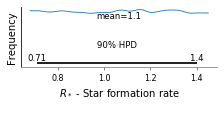

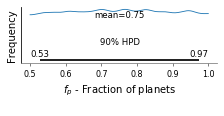

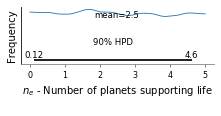

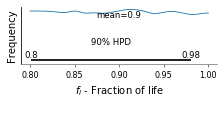

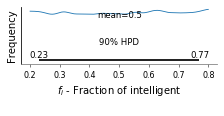

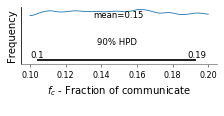

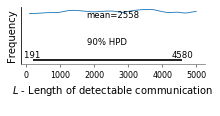

In [3]:
variables = [n for n in trace_uninformed.varnames if not n.endswith('__')][:-1]

for v in variables:
    ax = pm.plots.plot_posterior(trace_uninformed, 
                            varnames=[v], 
                            credible_interval=0.9, 
                            figsize=(3,1.5), 
                            textsize=8)[0]
    ax.spines["left"].set_visible(True)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(v + '\n')
    ax.set_title('')

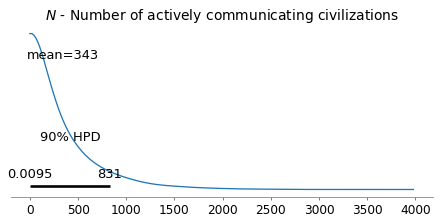

In [4]:
pm.plots.plot_posterior(trace_uninformed, 
                        varnames=[r'$N$ - Number of actively communicating civilizations'], 
                        credible_interval=0.9, 
                        figsize=(6,3));

## An Informed Guess
<a id='inf'></a>

Based on Wikipedia's Suggested Parameter Settings, the following parameter settings come to mind.

|Parameter|Estimate|Distribution|Parameters|
|:-:|:-:|:-:|:-:|
|$R_*$|0.68 - 1.45  |Gaussean|µ=1.15, σ=0.38|
|$f_p$|approaching 1|Beta    |α=5.0, β=1.0|
|$n_e$|1 - 5        |Gaussean|µ=3.0, σ=2.0  |
|$f_l$|approaching 1|Beta    |α=5.0, β=1.0|
|$f_i$|approaching 1|Beta    |α=5.0, β=1.0|
|$f_c$|0.1 - 0.2    |Gaussean|µ=0.15, σ=0.05|
|$L  $|0 - ∞, µ=300|Gamma   |α=300.0, β=1.0|

### Sampling Possible Outcomes

In [5]:
with pm.Model() as model_wiki:
    # Model parameters
    R   = pm.Normal(r'$R_*$ - Star formation rate', mu=1.15, sigma=0.38)
    f_p = pm.Beta(r'$f_p$ - Fraction of planets', alpha=5.0, beta=1.0)
    n_e = pm.Normal(r'$n_e$ - Number of planets supporting life', mu=3.0, sigma=2.0)
    f_l = pm.Beta(r'$f_l$ - Fraction of life', alpha=5.0, beta=1.0)
    f_i = pm.Beta(r'$f_i$ - Fraction of intelligent', alpha=5.0, beta=1.0)
    f_c = pm.Normal(r'$f_c$ - Fraction of communicate', mu=0.15, sigma=0.05)
    L   = pm.Gamma(r'$L$ - Length of detectable communication', alpha=300., beta=1.0)
    
    # Result
    N = pm.Deterministic(r'$N$ - Number of actively communicating civilizations', R * f_p * n_e * f_l * f_i * f_c * L)
    
    # Draw samples
    sampler = pm.NUTS()
    trace_wiki = pm.sample(5000, sampler)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$L$ - Length of detectable communication, $f_c$ - Fraction of communicate, $f_i$ - Fraction of intelligent, $f_l$ - Fraction of life, $n_e$ - Number of planets supporting life, $f_p$ - Fraction of planets, $R_*$ - Star formation rate]
Sampling 4 chains, 0 divergences: 100%|█████████████████████| 22000/22000 [00:14<00:00, 1554.82draws/s]


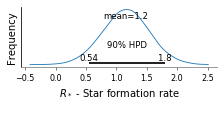

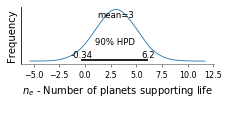

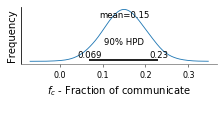

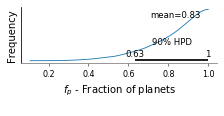

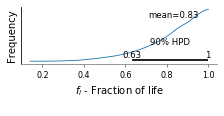

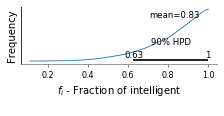

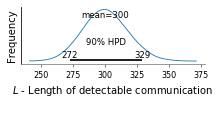

In [6]:
variables = [n for n in trace_wiki.varnames if not n.endswith('__')][:-1]

for v in variables:
    ax = pm.plots.plot_posterior(trace_wiki, 
                            varnames=[v], 
                            credible_interval=0.9, 
                            figsize=(3,1.5), 
                            textsize=8)[0]
    ax.spines["left"].set_visible(True)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(v + '\n')
    ax.set_title('')

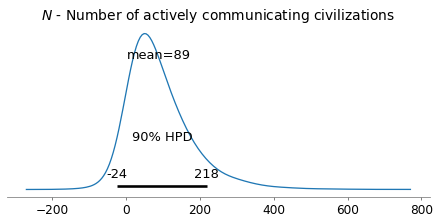

In [7]:
pm.plots.plot_posterior(trace_wiki, 
                        varnames=[r'$N$ - Number of actively communicating civilizations'], 
                        credible_interval=0.9, 
                        figsize=(6,3));

## An Enhanced Guess

This scenario bases on the suggestions of the Wikipedia article and incorporates **two enhancements** to the previous model:

- The length of the detectable communication $L$ is highly uncertain. Therefor this approach **adjusts the hyperparameter $\alpha$ of the underlying Gamma-Distribution** to draw samples from. In this estimate scenario, the mean of the Gamma-Distribution is normal distributed around 310, with a variance of 50.
- Some parameters may draw samples with negative values. as this does not make sense (e.g. for the fraction of stars, developing life), the **samples are truncated below zero**.

|Parameter|Estimate|Distribution|Parameters|Enhancement|
|:-:|:-:|:-:|:-:|:-:|
|$R_*$|0.68 - 1.45  |Gaussean|µ=1.15, σ=0.38|truncated below zero|
|$f_p$|approaching 1|Beta    |α=5, β=1||
|$n_e$|1 - 5        |Gaussean|µ=3, σ=2  |truncated below zero|
|$f_l$|approaching 1|Beta    |α=5, β=1||
|$f_i$|approaching 1|Beta    |α=5, β=1||
|$f_c$|0.1 - 0.2    |Gaussean|µ=0.15, σ=0.05|truncated below zero|
|$L  $|0 - ∞, µ=300|Gamma   |α=$\mathcal{N}$(µ=310,σ=50), β=1|$\alpha$ not fix|

### Sampling Possible Outcomes

In [8]:
with pm.Model() as model_hyper:
    # Model parameters
    R   = pm.Bound(pm.Normal, lower=0.0)(r'$R_*$ - Star formation rate', mu=1.15, sigma=0.38)
    f_p = pm.Beta(r'$f_p$ - Fraction of planets', alpha=5.0, beta=1.0)
    n_e = pm.Bound(pm.Normal, lower=0.0)(r'$n_e$ - Number of planets supporting life', mu=3.0, sigma=2.0)
    f_l = pm.Beta(r'$f_l$ - Fraction of life', alpha=5.0, beta=1.0)
    f_i = pm.Beta(r'$f_i$ - Fraction of intelligent', alpha=5.0, beta=1.0)
    f_c = pm.Bound(pm.Normal, lower=0.0)(r'$f_c$ - Fraction of communicate', mu=0.15, sigma=0.05)
    l_alpha = pm.Normal(r'$\alpha(\Gamma_L)$', mu=360., sigma=50.)
    L   = pm.Gamma(r'$L$ - Length of detectable communication', alpha=l_alpha, beta=1.0)
    
    # Result
    N = pm.Deterministic(r'$N$ - Number of actively communicating civilizations', R * f_p * n_e * f_l * f_i * f_c * L)
    
    # Draw samples
    sampler = pm.NUTS()
    trace_hyper = pm.sample(5000, sampler)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$L$ - Length of detectable communication, $\alpha(\Gamma_L)$, $f_c$ - Fraction of communicate, $f_i$ - Fraction of intelligent, $f_l$ - Fraction of life, $n_e$ - Number of planets supporting life, $f_p$ - Fraction of planets, $R_*$ - Star formation rate]
Sampling 4 chains, 0 divergences: 100%|█████████████████████| 22000/22000 [00:17<00:00, 1294.10draws/s]


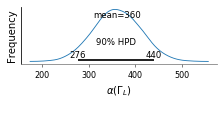

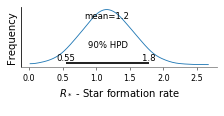

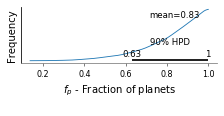

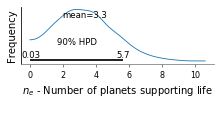

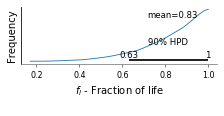

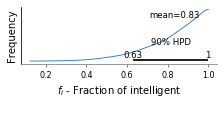

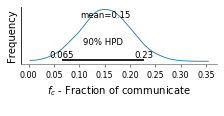

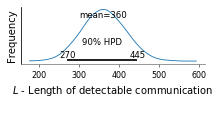

In [9]:
variables = [n for n in trace_hyper.varnames if not n.endswith('__')][:-1]

for v in variables:
    ax = pm.plots.plot_posterior(trace_hyper, 
                            varnames=[v], 
                            credible_interval=0.9, 
                            figsize=(3,1.5), 
                            textsize=8)[0]
    ax.spines["left"].set_visible(True)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(v + '\n')
    ax.set_title('')

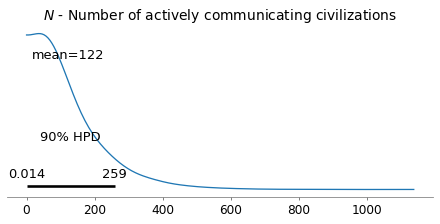

In [10]:
pm.plots.plot_posterior(trace_hyper, 
                        varnames=[r'$N$ - Number of actively communicating civilizations'], 
                        credible_interval=0.9, 
                        figsize=(6,3));

# Comparing the results of the three approaches

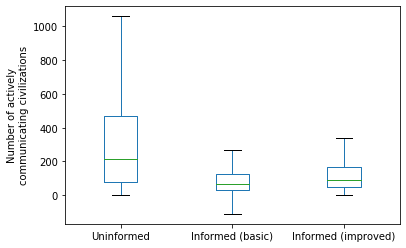

In [15]:
n = r'$N$ - Number of actively communicating civilizations'
results = pd.DataFrame(data=np.array([trace_uninformed[n], trace_wiki[n], trace_hyper[n]]).T, 
                       columns = ['Uninformed', 'Informed (basic)', 'Informed (improved)'])

ax = results.plot(kind='box', showfliers=False)
ax.set_ylabel('Number of actively\ncommunicating civilizations');

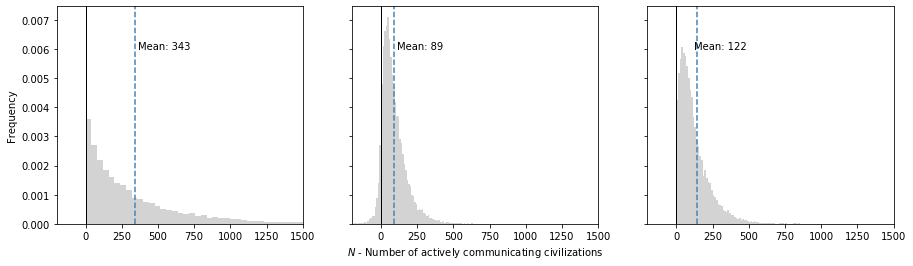

In [14]:
n = r'$N$ - Number of actively communicating civilizations'
mean1 = trace_uninformed[n].mean()
mean2 = trace_wiki[n].mean()
mean3 = trace_hyper[n].mean()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4), sharex=True, sharey=True)
ax1.hist(trace_uninformed[n], bins=100, density=True, color='lightgrey')
ax1.axvline(mean1, linestyle='--', color='steelblue')
ax1.axvline(0, color='k', linewidth=1)
ax1.text(mean1+20, 0.006, f'Mean: {mean1:.0f}')
ax1.set(ylabel='Frequency')
ax1.set_xlim(-200,1500)

ax2.hist(trace_wiki[n], bins=100, density=True, color='lightgrey')
ax2.axvline(mean2, linestyle='--', color='steelblue')
ax2.axvline(0, color='k', linewidth=1)
ax2.text(mean2+20, 0.006, f'Mean: {mean2:.0f}')
ax2.set(xlabel=n)

ax3.hist(trace_hyper[n], bins=100, density=True, color='lightgrey')
ax3.axvline(mean3+20, linestyle='--', color='steelblue')
ax3.axvline(0, color='k', linewidth=1)
ax3.text(mean3, 0.006, f'Mean: {mean3:.0f}')

plt.show()

# Conclusion

Arguably, the choice of the priors doesn't have a super strong impact. All distributions exhibit roughly an exponential decay and the means are in the same oder of magnitude. The results of the more informed priors go in line with the estimate of the [guesstimate](https://www.getguesstimate.com/models/2734) tool (~120).

Now, having a grasp on how many actively communicating extraterrestrial civilizations we should in theory be able to observe, it remains open, why we don't. This is called the [Fermi paradox](https://en.wikipedia.org/wiki/Fermi_paradox#Hypothetical_explanations_for_the_paradox) and the list of possible explanations is long.